<a href="https://colab.research.google.com/github/pinilDissanayaka/Pneumonia-Detection-using-Deep-Learning/blob/main/Pneumonia_Detection_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [2]:
! kaggle datasets download tolgadincer/labeled-chest-xray-images

100% 1.17G/1.17G [00:08<00:00, 154MB/s]
100% 1.17G/1.17G [00:08<00:00, 141MB/s]


In [3]:
! unzip /content/labeled-chest-xray-images.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/NORMAL-2558319-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2558319-0002.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2559035-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2559035-0002.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2565226-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2568157-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2597757-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2597757-0002.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-263932-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2646645-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2646923-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2655558-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2659844-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2675017-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2675017-00

In [4]:
!pip install livelossplot
!pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 10.5 MB/s eta 0:00:00


In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
import cv2 as cv
from glob import glob
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAvgPool2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from livelossplot import PlotLossesKerasTF
import visualkeras

%matplotlib inline

import warnings
warnings.filterwarnings(action = 'ignore')

In [7]:
mainDir = '/content/chest_xray'

In [8]:
mainDirList = os.listdir(mainDir)
mainDirList

['test', 'train']

In [9]:
trainDir = mainDir + '/' + mainDirList[1]
testDir = mainDir + '/' + mainDirList[0]


print(f"Training directory : {trainDir}")
print(f"Testing directory : {testDir}")

Training directory : /content/chest_xray/train
Testing directory : /content/chest_xray/test


In [10]:
outDir = '/content/output'

if not os.path.exists(outDir):
  os.mkdir(outDir)

figDir = outDir + "/fig"
if not os.path.exists(figDir):
  os.mkdir(figDir)

modelDir = outDir + "/model"
if not os.path.exists(modelDir):
  os.mkdir(modelDir)

In [11]:
trainLabels = os.listdir(trainDir)
testLabels = os.listdir(testDir)

print(f"Training labels : {trainLabels}")
print()
print(f"Testing labels : {testLabels}")

Training labels : ['NORMAL', 'PNEUMONIA']

Testing labels : ['NORMAL', 'PNEUMONIA']


In [12]:
def plotImgs(dir, labels, nrows, ncols):
  for label in labels:
    temp = dir + '/' + label
    temp = glob(temp + '/*')
    imgToPrint = np.random.choice(temp, size = nrows*ncols)
    plt.figure(figsize = (25, 25))
    for i in range(len(imgToPrint)):
      img = plt.imread(imgToPrint[i])
      plt.subplot(nrows, ncols, i + 1)
      plt.imshow(img, cmap = 'gray')
      plt.title(label)
      plt.grid('off')
      plt.axis('off')
    plt.savefig(figDir + f'/{label}')
  plt.show()

In [13]:
for label in trainLabels:
  temp = trainDir + '/' + label
  print(temp)

/content/chest_xray/train/NORMAL
/content/chest_xray/train/PNEUMONIA


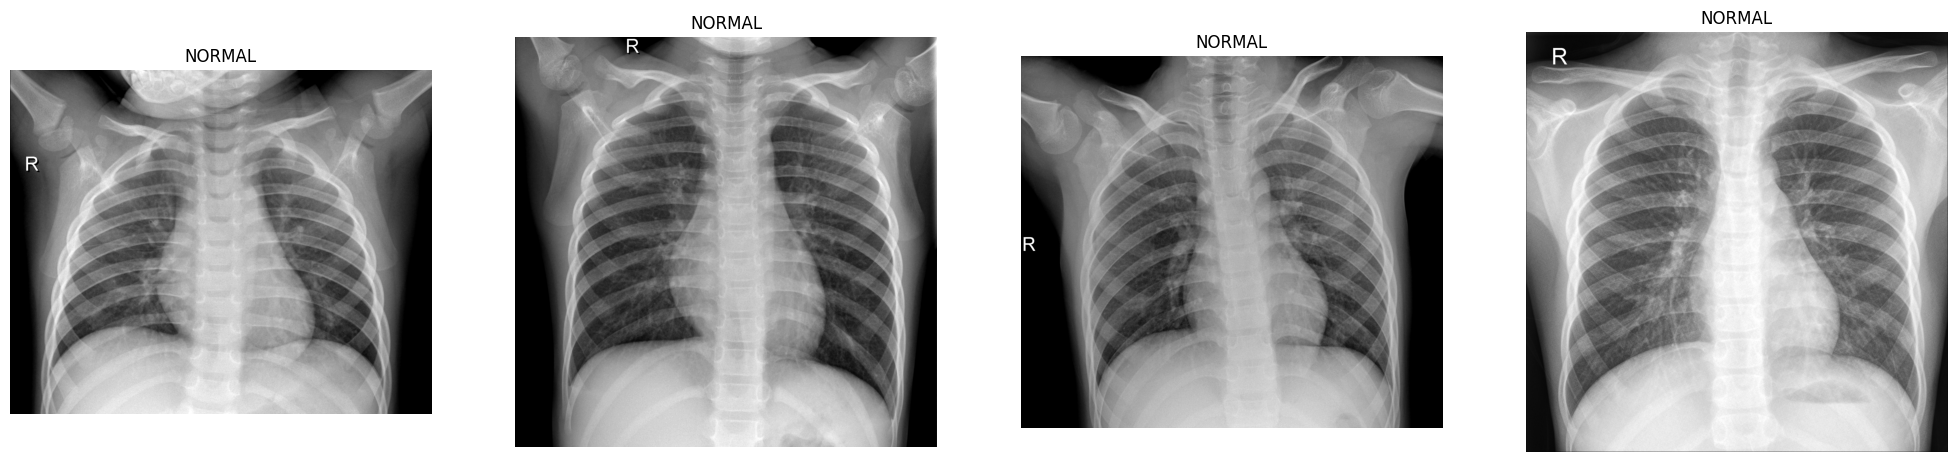

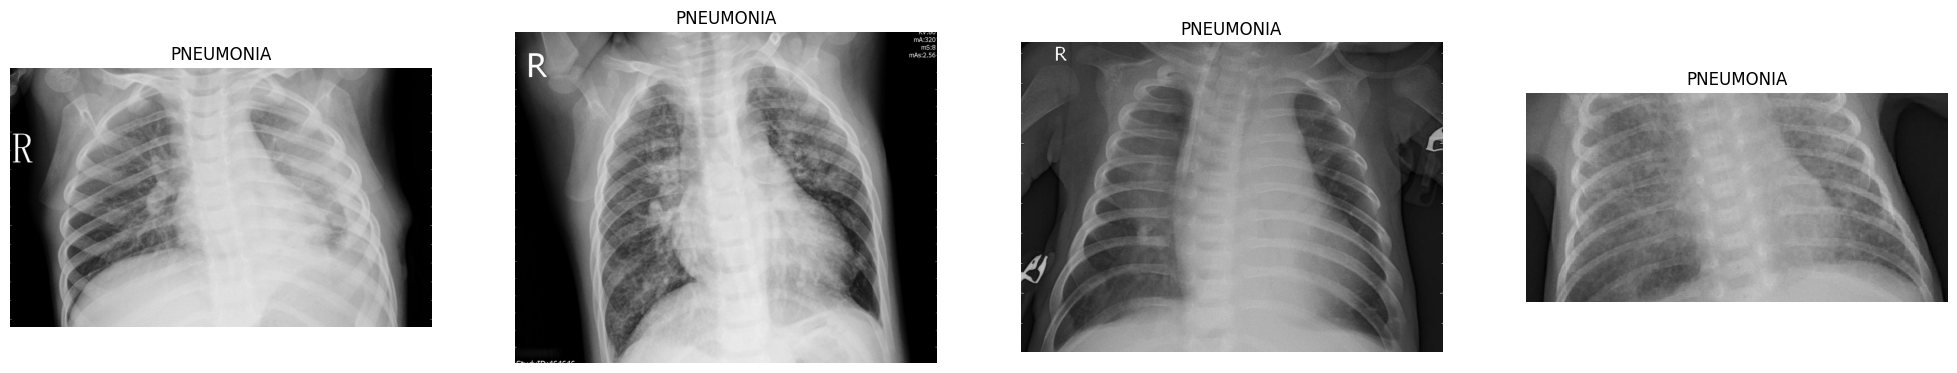

In [14]:
plotImgs(trainDir, trainLabels, 1, 4)

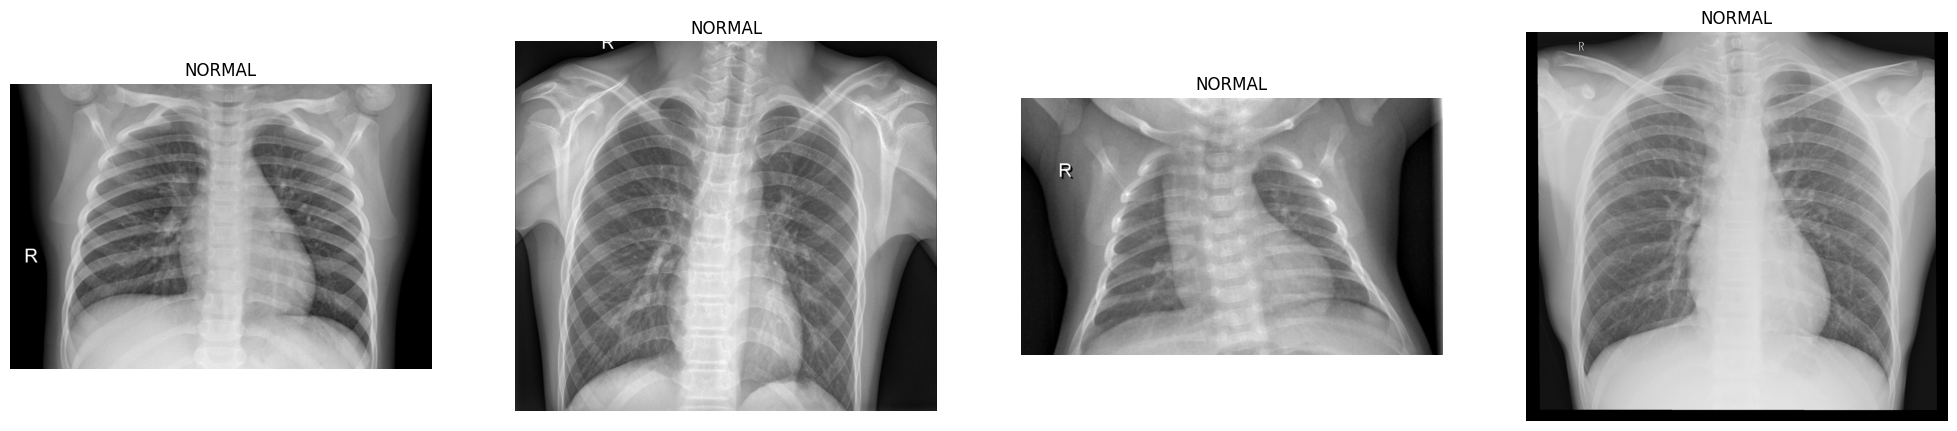

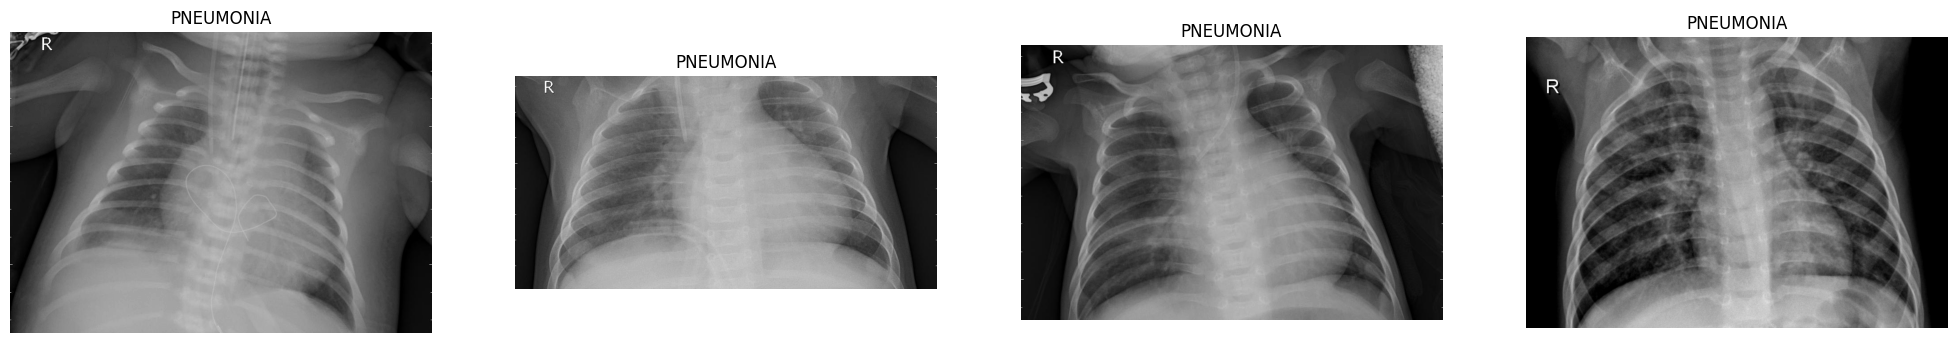

In [15]:
plotImgs(testDir, testLabels, 1, 4)

In [16]:
trainImgCount = {}
testImgCount = {}

def getImgCount(dir, labels, dic):
  for label in labels:
    temp = dir + '/' + label
    temp = glob(temp + '/*')
    dic[label] = len(temp)

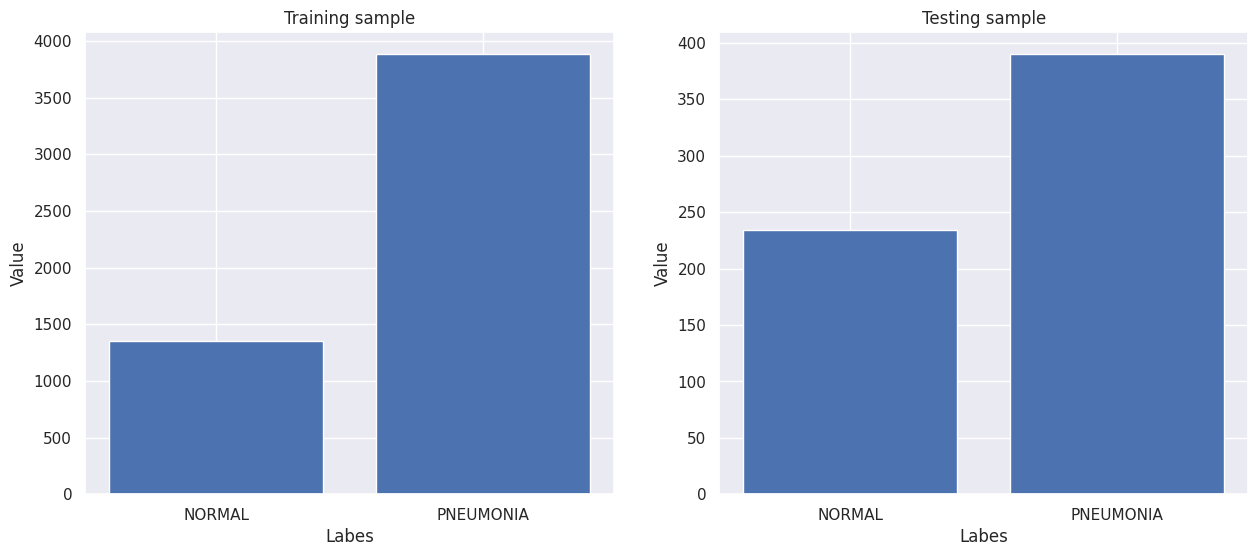

In [17]:
sns.set()
plt.figure(figsize = (15, 6))

plt.subplot(1, 2, 1)
getImgCount(trainDir, trainLabels, trainImgCount)
keys = trainImgCount.keys()
values = trainImgCount.values()
plt.bar(keys,values)
plt.xlabel('Labes')
plt.ylabel('Value')
plt.title('Training sample')
plt.savefig(figDir + f'/Training sample')


plt.subplot(1, 2, 2)
getImgCount(testDir, testLabels, testImgCount)
keys = testImgCount.keys()
values = testImgCount.values()
plt.bar(keys,values)
plt.xlabel('Labes')
plt.ylabel('Value')
plt.title('Testing sample')
plt.savefig(figDir + f'/Testing sample')


plt.show()

In [19]:
targetSize = [124, 124]
inputSize = targetSize + [1]
outputSize = len(trainLabels)
batchSize = 25
rescale = 1./ 255
epochs = 100


trainGen = ImageDataGenerator(rescale=rescale,
                              horizontal_flip = True,
                              vertical_flip = True,
                              shear_range=16,
                              validation_split =0.2)

testGen = ImageDataGenerator(rescale=rescale)


trainGenerator = trainGen.flow_from_directory(trainDir,
                                              target_size=targetSize,
                                              class_mode='categorical',
                                              color_mode = 'grayscale',
                                              batch_size = batchSize,
                                              shuffle = True,
                                              subset = 'training')

validGenerator = trainGen.flow_from_directory(trainDir,
                                              target_size=targetSize,
                                              class_mode='categorical',
                                              color_mode = 'grayscale',
                                              batch_size = batchSize,
                                              shuffle = True,
                                              subset = 'validation')

testGenerator = testGen.flow_from_directory(testDir,
                                              target_size=targetSize,
                                              class_mode='categorical',
                                              color_mode = 'grayscale',
                                              batch_size = batchSize)

Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [20]:
stepsPertrainingEpoch = trainGenerator.n // trainGenerator.batch_size
stepsPerValidationEpoch = validGenerator.n // validGenerator.batch_size
stepsPerTestingEpoch = testGenerator.n // testGenerator.batch_size


print(f"Every training epoch has {stepsPertrainingEpoch} steps.")
print(f"Every training epoch has {stepsPertrainingEpoch} steps.")
print(f"Every testing epoch has {stepsPerTestingEpoch} steps.")

Every training epoch has 167 steps.
Every training epoch has 167 steps.
Every testing epoch has 24 steps.


In [21]:
classIndices = trainGenerator.class_indices

print(f"Class Indices : {classIndices}")

outClass = {v : k for k, v in classIndices.items()}

print(f"Output classes : {outClass}")

Class Indices : {'NORMAL': 0, 'PNEUMONIA': 1}
Output classes : {0: 'NORMAL', 1: 'PNEUMONIA'}


In [22]:
y = trainGenerator.classes

classWeight = class_weight.compute_class_weight(class_weight = 'balanced',classes= np.unique(y), y=y)

print(f"class weights : {classWeight}")

classWeights = {}

for i, j in enumerate(np.unique(y)):
  classWeights[j] = classWeight[i]

print(f"class weights for each class : {classWeights}")

class weights : [1.93842593 0.67380109]
class weights for each class : {0: 1.938425925925926, 1: 0.6738010943031864}


In [37]:
model = Sequential()

model.add(Conv2D(16, (3, 3), activation='relu', padding="same", input_shape=inputSize))
model.add(Conv2D(16, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(Conv2D(32, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Conv2D(96, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
model.add(Conv2D(96, (3, 3), padding="valid", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Conv2D(128, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
model.add(Conv2D(128, (3, 3), padding="valid", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(GlobalAvgPool2D())

model.add(BatchNormalization())

model.add(Dense(units = outputSize , activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 124, 124, 16)      160       
                                                                 
 conv2d_31 (Conv2D)          (None, 124, 124, 16)      2320      
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 62, 62, 16)        0         
 ng2D)                                                           
                                                                 
 dropout_19 (Dropout)        (None, 62, 62, 16)        0         
                                                                 
 batch_normalization_21 (Ba  (None, 62, 62, 16)        64        
 tchNormalization)                                               
                                                                 
 conv2d_32 (Conv2D)          (None, 62, 62, 32)       

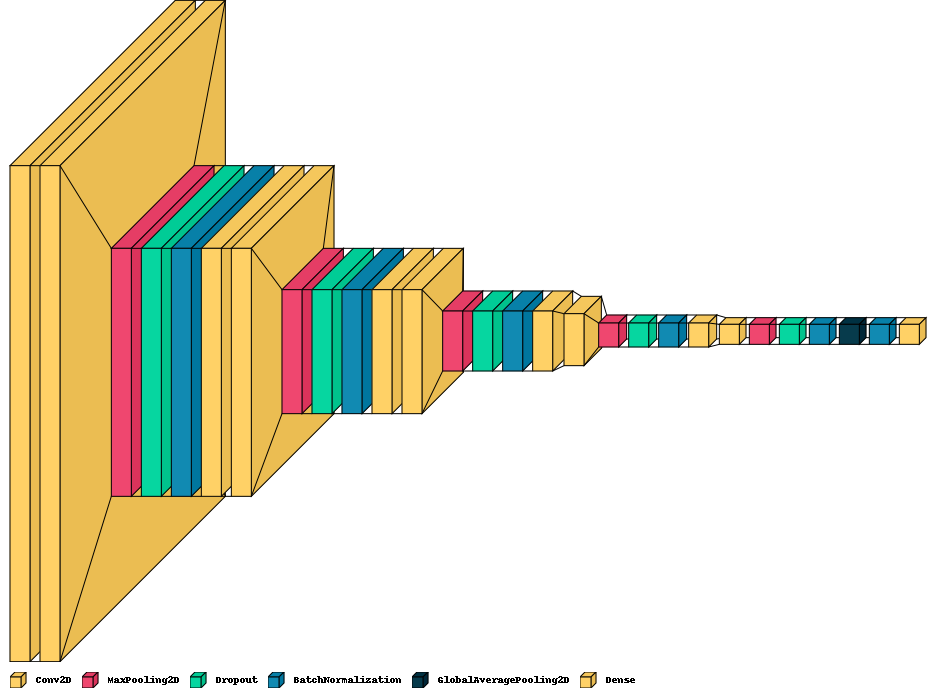

In [38]:
visualkeras.layered_view(model, legend =True)

In [39]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [40]:
earlyStopping = EarlyStopping(monitor='val_loss',
                              patience=2,
                              verbose=1)

reduceLr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.1,
                              patience=2,
                              min_lr=0.000001,
                              model='auto')

modelCheck = ModelCheckpoint(modelDir + "/model_weights.h5",
                             monitor="val_accuracy",
                             save_weights_only=True,
                             mode="max",
                             verbose=1)


callBacks = [earlyStopping, reduceLr, modelCheck, PlotLossesKerasTF()]

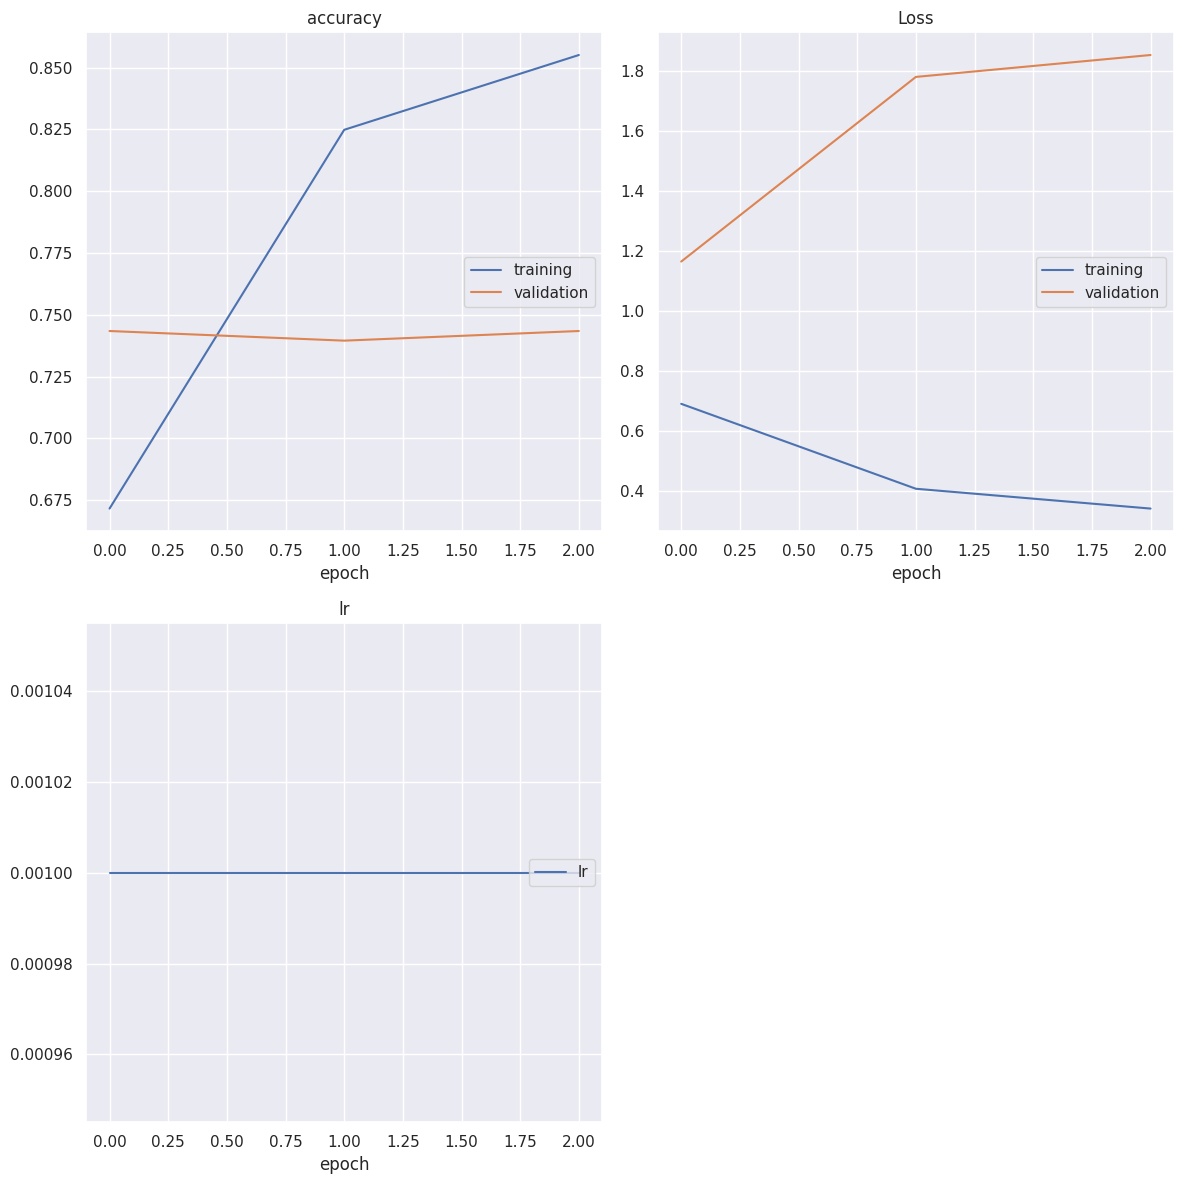

accuracy
	training         	 (min:    0.672, max:    0.855, cur:    0.855)
	validation       	 (min:    0.740, max:    0.743, cur:    0.743)
Loss
	training         	 (min:    0.340, max:    0.689, cur:    0.340)
	validation       	 (min:    1.164, max:    1.854, cur:    1.854)
lr
	lr               	 (min:    0.001, max:    0.001, cur:    0.001)
167/167 [==============================] - 39s 236ms/step - loss: 0.3397 - accuracy: 0.8551 - val_loss: 1.8535 - val_accuracy: 0.7434 - lr: 0.0010
Epoch 3: early stopping


In [41]:
modelHist = model.fit_generator(trainGenerator,
                                steps_per_epoch=stepsPertrainingEpoch,
                                epochs = epochs,
                                verbose=1,
                                callbacks=callBacks,
                                validation_data=validGenerator,
                                validation_steps=stepsPerValidationEpoch,
                                workers=-1,
                                use_multiprocessing=True,
                                shuffle=True)